# Installation

In [ ]:
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.6/626.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.1/678.1 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

# Imports


In [ ]:
#load packages
import pandas as pd
import numpy as np
import os.path
import os
import random
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, PredefinedSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from concrete.ml.sklearn import XGBRegressor as ConcreteXGBRegressor
from concrete.ml.sklearn import Ridge
from concrete.ml.deployment import FHEModelDev, FHEModelClient, FHEModelServer
import matplotlib.pyplot as plt
import time

# Data Loading


<b>Download the Preprocessed training data:</b>

- Train Data (<b>combined_train.csv</b>): https://drive.google.com/file/d/1-1jQb6ScTOYzyxfDTpjqJeTvleLBsxXA/
-Test Data (<b>combined_test.csv</b>): https://drive.google.com/file/d/12LGzOoZeAOiJnVr5S4EICnYWRdPnptQD/

Place them in your train and test folders


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/.../ConcreteBioage

In [ ]:
train_df = pd.read_csv("./train/combined_train.csv").iloc[:, 1:]
test_df = pd.read_csv("./test/combined_test.csv").iloc[:, 1:]

# Preprocessing

In [ ]:
def preprocess_data(df):

    pat_data = df[['dataset', 'tissue_type', 'age', 'gender']]
    df = df.drop(columns = ['dataset', 'tissue_type', 'age', 'gender'], axis = 0)
    indexes = df.index
    df = df.astype('float64')

    print('Shape of the dataframe:')
    print(df.shape)

    print('Number of NAs:')
    print(np.sum(pd.DataFrame(df).isna().any()))

    imputer = KNNImputer()
    df = imputer.fit_transform(df)

    gs = pd.read_csv('./gold_standard.csv')
    gs_cpgs = np.array(gs.Name)

    df = pd.DataFrame(df, columns = gs_cpgs, index = indexes)
    df = pd.concat([pat_data, df], axis=1, sort=False, join='inner')

    return df

In [ ]:
train = preprocess_data(train_df)
test = preprocess_data(test_df)

Shape of the dataframe:
(8050, 21368)
Number of NAs:
0
Shape of the dataframe:
(5455, 21368)
Number of NAs:
0


In [ ]:
def get_scaled_data(data):
  data_ages = data['age'].astype('float64')

  data_info = data[['dataset', 'tissue_type', 'age', 'gender']]
  data = data.drop(columns = ['dataset', 'tissue_type', 'age', 'gender'], axis=0)

  data_cols = data.columns
  data_index = data.index

  scaler = preprocessing.StandardScaler()
  #scaler = preprocessing.RobustScaler()

  data_scaled = pd.DataFrame(scaler.fit_transform(data), index = data_index, columns = data_cols)
  np.save("./means_train.npy", np.array(scaler.mean_))
  np.save("./variance_train.npy", np.sqrt(np.array(scaler.var_)))

  return data_scaled, data_ages

In [ ]:
train_scaled, train_ages = get_scaled_data(train)
test_scaled, test_ages = get_scaled_data(test)

In [ ]:
train_scaled
#test_scaled

,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00011459,cg00012199,...,cg27650175,cg27650434,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27662379,cg27662877,cg27665659
0,0.671917,0.925495,0.928118,0.018260,1.954693,0.457207,-1.254751,-0.880913,0.463006,-0.345535,...,-0.461577,-0.931816,-0.931975,0.517841,-0.911718,-1.108150,0.430969,-0.374165,-0.701712,-0.834000
1,0.705224,0.829852,-0.455569,-0.427539,1.617096,0.476096,-0.364827,-0.993970,0.232412,-0.731246,...,-0.415071,-0.398567,-0.817415,0.436550,-0.565861,-0.437285,-0.008975,-1.052358,-0.505070,-0.880381
2,0.666858,0.715897,-0.020523,-0.247837,0.689927,0.422341,-0.995150,-0.859279,-0.024915,-0.929957,...,-0.475985,0.091989,-0.905192,0.364677,-1.043282,0.203386,0.243932,-0.534174,-0.672095,-0.641470
3,0.988973,0.848502,-0.448827,-0.646449,0.784485,0.450761,-0.450825,-0.918101,0.487792,-0.778824,...,-0.441893,0.573411,-1.003452,0.790781,-0.707193,-0.413068,-0.180585,-0.668976,-0.804158,-0.522947
4,0.766668,0.439313,0.413780,-0.622320,0.081508,0.427733,-1.096055,0.744667,-1.395332,-0.923520,...,-0.471631,-1.240014,-0.685836,0.244981,-1.077561,-0.130157,1.413205,-0.603394,-0.638057,-1.096026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8045,0.232088,-1.027428,-0.062576,0.982743,-0.675927,0.215989,0.374957,-0.439531,-0.702825,-0.046023,...,-0.348102,0.697415,2.091713,-0.478423,-0.432959,-0.971489,-0.748491,0.020090,0.164825,2.061029
8046,-0.103944,-0.544826,-0.669850,2.254891,-0.475262,0.193672,0.976969,-0.020136,-1.074384,0.752249,...,-0.354621,0.031190,1.255057,-0.254561,-0.487563,-0.628223,-0.610812,0.406431,-0.436990,1.261557
8047,0.240613,-1.049102,-0.096024,1.131589,-0.363768,0.199815,-0.370802,-0.621973,-0.292270,0.237091,...,-0.226891,-0.880754,2.199584,0.106570,-0.439681,-0.610464,-0.741492,1.541890,2.682218,0.526813
8048,-0.531644,-0.202277,-0.453956,2.906278,-0.578755,0.260453,0.079774,-0.315718,0.187751,0.182756,...,-0.260339,0.436106,0.780981,0.161930,0.045264,-1.045244,-0.734425,-0.057124,-0.667911,3.145518


# Data Splitting

In [ ]:
random_seed = 42
print("\n--- Splitting Data (Train/Test) ---")
test_set_size = 0.1 # 10% for testing

X_train, X_val, y_train, y_val = train_test_split(
    train_scaled, train_ages, test_size=test_set_size, random_state=random_seed
)

print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_val.shape}, y={y_val.shape}")


--- Splitting Data (Train/Test) ---
Train set shape: X=(7245, 21368), y=(7245,)
Test set shape: X=(805, 21368), y=(805,)


# Modeling

## XGB Regressor 6 bits

In [ ]:
print("\n--- Initializing XGB Model ---")

n_estimators = 50
max_depth = 4
n_jobs = -1
n_bits = 6

concrete_xgb_reg = ConcreteXGBRegressor(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs
)
print(concrete_xgb_reg)

start_time = time.time()
concrete_xgb_reg.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    verbose=True # Show training progress
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing XGB Model ---
XGBRegressor(max_depth=4, n_estimators=50, n_jobs=-1)
[0]	validation_0-rmse:39.33639
[1]	validation_0-rmse:32.12850
[2]	validation_0-rmse:29.26695
[3]	validation_0-rmse:28.93349
[4]	validation_0-rmse:28.41751
[5]	validation_0-rmse:28.45161
[6]	validation_0-rmse:28.43538
[7]	validation_0-rmse:28.51146
[8]	validation_0-rmse:28.61330
[9]	validation_0-rmse:28.90562
[10]	validation_0-rmse:29.08298
[11]	validation_0-rmse:29.20073
[12]	validation_0-rmse:29.60108
[13]	validation_0-rmse:29.63844
[14]	validation_0-rmse:29.86582
[15]	validation_0-rmse:29.26065
[16]	validation_0-rmse:28.72861
[17]	validation_0-rmse:28.70049
[18]	validation_0-rmse:28.67111
[19]	validation_0-rmse:28.66879
[20]	validation_0-rmse:28.66510
[21]	validation_0-rmse:28.55779
[22]	validation_0-rmse:28.55701
[23]	validation_0-rmse:28.55686
[24]	validation_0-rmse:28.55660
[25]	validation_0-rmse:28.55662
[26]	validation_0-rmse:28.55828
[27]	validation_0-rmse:28.55816
[28]	validation_0-rmse:28.56

## XGB Regressor 8 bits

In [ ]:
print("\n--- Initializing XGB Model ---")

n_estimators = 50
max_depth = 4
n_jobs = -1
n_bits = 8

concrete_xgb_reg = ConcreteXGBRegressor(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs
)
print(concrete_xgb_reg)

start_time = time.time()
concrete_xgb_reg.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    verbose=True # Show training progress
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing XGB Model ---
XGBRegressor(max_depth=4, n_bits=8, n_estimators=50, n_jobs=-1)
[0]	validation_0-rmse:39.32684
[1]	validation_0-rmse:35.94292
[2]	validation_0-rmse:32.25308
[3]	validation_0-rmse:29.31330
[4]	validation_0-rmse:29.22418
[5]	validation_0-rmse:28.49646
[6]	validation_0-rmse:28.48946
[7]	validation_0-rmse:28.52987
[8]	validation_0-rmse:28.40229
[9]	validation_0-rmse:28.40838
[10]	validation_0-rmse:28.43746
[11]	validation_0-rmse:28.43595
[12]	validation_0-rmse:28.47688
[13]	validation_0-rmse:28.44562
[14]	validation_0-rmse:28.58315
[15]	validation_0-rmse:29.45370
[16]	validation_0-rmse:28.43697
[17]	validation_0-rmse:28.40811
[18]	validation_0-rmse:28.40691
[19]	validation_0-rmse:28.41109
[20]	validation_0-rmse:28.42981
[21]	validation_0-rmse:28.46047
[22]	validation_0-rmse:28.49950
[23]	validation_0-rmse:28.45670
[24]	validation_0-rmse:28.40925
[25]	validation_0-rmse:28.50332
[26]	validation_0-rmse:28.50506
[27]	validation_0-rmse:28.51485
[28]	validation_0-

## XGB Regressor 10 bits

In [ ]:
print("\n--- Initializing XGB Model ---")

n_estimators = 50
max_depth = 4
n_jobs = -1
n_bits = 10

concrete_xgb_reg = ConcreteXGBRegressor(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs
)
print(concrete_xgb_reg)

start_time = time.time()
concrete_xgb_reg.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_val.to_numpy(), y_val.to_numpy())],
    verbose=True # Show training progress
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing XGB Model ---
XGBRegressor(max_depth=4, n_bits=10, n_estimators=50, n_jobs=-1)
[0]	validation_0-rmse:39.48500
[1]	validation_0-rmse:36.23753
[2]	validation_0-rmse:31.43949
[3]	validation_0-rmse:29.11227
[4]	validation_0-rmse:28.57422
[5]	validation_0-rmse:28.42181
[6]	validation_0-rmse:28.42370
[7]	validation_0-rmse:28.41403
[8]	validation_0-rmse:28.45569
[9]	validation_0-rmse:28.49376
[10]	validation_0-rmse:28.80600
[11]	validation_0-rmse:28.58103
[12]	validation_0-rmse:28.54823
[13]	validation_0-rmse:28.56058
[14]	validation_0-rmse:28.60003
[15]	validation_0-rmse:28.94866
[16]	validation_0-rmse:28.96804
[17]	validation_0-rmse:28.76447
[18]	validation_0-rmse:28.77325
[19]	validation_0-rmse:28.78225
[20]	validation_0-rmse:28.54751
[21]	validation_0-rmse:28.52315
[22]	validation_0-rmse:29.39341
[23]	validation_0-rmse:30.32749
[24]	validation_0-rmse:29.16547
[25]	validation_0-rmse:29.16218
[26]	validation_0-rmse:29.16016
[27]	validation_0-rmse:29.32680
[28]	validation_0

## Ridge Model 4 bits

In [ ]:
print("\n--- Initializing Ridge Model ---")

n_bits = 4

concrete_ridge_model = Ridge(
    n_bits=n_bits,

)
print(concrete_ridge_model)

start_time = time.time()
concrete_ridge_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing Ridge Model ---
Ridge(n_bits=4)
Final model training completed in 10.16 seconds.


## Ridge Model 5 bits

In [ ]:
print("\n--- Initializing Ridge Model ---")

n_bits = 5

concrete_ridge_model = Ridge(
    n_bits=n_bits,

)
print(concrete_ridge_model)

start_time = time.time()
concrete_ridge_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing Ridge Model ---
Ridge(n_bits=5)
Final model training completed in 10.12 seconds.


## Ridge Model 6 bits

In [ ]:
print("\n--- Initializing Ridge Model ---")

n_bits = 6

concrete_ridge_model = Ridge(
    n_bits=n_bits,

)
print(concrete_ridge_model)

start_time = time.time()
concrete_ridge_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing Ridge Model ---
Ridge(n_bits=6)
Final model training completed in 10.65 seconds.


## Ridge Model 8 bits

In [ ]:
print("\n--- Initializing Ridge Model ---")

n_bits = 8

concrete_ridge_model = Ridge(
    n_bits=n_bits,

)
print(concrete_ridge_model)

start_time = time.time()
concrete_ridge_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing Ridge Model ---
Ridge()
Final model training completed in 9.75 seconds.


## Ridge Model 10 bits

In [ ]:
print("\n--- Initializing Ridge Model ---")

n_bits = 10

concrete_ridge_model = Ridge(
    n_bits=n_bits,

)
print(concrete_ridge_model)

start_time = time.time()
concrete_ridge_model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
)
print(f"Final model training completed in {time.time() - start_time:.2f} seconds.")


--- Initializing Ridge Model ---
Ridge(n_bits=10)
Final model training completed in 10.44 seconds.


# ConcreteML Deploymemnt

In [ ]:
final_model = concrete_xgb_reg
#final_model = concrete_ridge_model

In [ ]:
cd /content

/content


In [ ]:
# Define the directory for FHE client/server files
fhe_directory = './weights'
final_model.compile(X_train)
# Setup the development environment
dev = FHEModelDev(path_dir=fhe_directory, model=final_model)
dev.save()

# Setup the client
client = FHEModelClient(path_dir=fhe_directory, key_dir="./weights/keys_client")
serialized_evaluation_keys = client.get_serialized_evaluation_keys()


In [ ]:
# Client pre-processes new data
encrypted_data = client.quantize_encrypt_serialize(X_val.to_numpy()[:1])

# Setup the server
server = FHEModelServer(path_dir=fhe_directory)
server.load()

# Server processes the encrypted data
encrypted_result = server.run(encrypted_data, serialized_evaluation_keys)

# Client decrypts the result
result = client.deserialize_decrypt_dequantize(encrypted_result)

In [ ]:
print(result)

In [ ]:
fhe_circuit = final_model.compile(X_train)
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")


Key generation time: 2.4345 seconds


# Inference on Test Data

In [ ]:
X_val = test_scaled
y_val = test_ages
n_samples_pred = 100

In [ ]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = final_model.predict(X_val[0:n_samples_pred], fhe="execute")

print(f"Execution time: {time.time()-time_begin}")
#500 s for Ridge 5bits

In [ ]:
def calculate_metrics(y_true, y_predicted):
  """
  Calculates Mean Squared Error (MSE), Mean Absolute Error (MAE), and
  Root Mean Squared Error (RMSE) from NumPy arrays of true and predicted values.

  Args:
    y_true (np.ndarray): Array of true (actual) values.
    y_predicted (np.ndarray): Array of predicted values.

  Returns:
    dict: A dictionary containing the MSE, MAE, and RMSE.
          Returns None if the input arrays have different shapes.
  """
  if y_true.shape != y_predicted.shape:
    print("Error: True and predicted arrays must have the same shape.")
    return None

  mse = np.mean((y_true - y_predicted)**2)
  mae = np.mean(np.abs(y_true - y_predicted))
  rmse = np.sqrt(mse)

  metrics = {
      'mse': mse,
      'mae': mae,
      'rmse': rmse,
  }
  return metrics

In [ ]:
y_pred_fhe = np.maximum(0, y_pred_fhe)

In [ ]:
print("Actual ages ----> ", [ int(i) for i in y_val.to_numpy()[0:n_samples_pred]])
print("Predicted ages ---->", [ int(i) for i in y_pred_fhe])

In [ ]:
calculate_metrics(y_val[0:n_samples_pred], y_pred_fhe)

In [ ]:
Ridge 4 bits ---->
{'mse': 1161.4358373449131, 'mae': 31.517142562242867, 'rmse': 34.079845031116456}

Ridge 5 bits ---->
{'mse': 87.40573682605505, 'mae': 6.5281055137308295, 'rmse': 9.3491035306095}

Ridge 6 bits ---->
{'mse': 33.35124638125943, 'mae': 2.868349465474243, 'rmse': 5.775053798992649}

Ridge 8 bits ---->
 {'mse': 21.19793535517247, 'mae': 2.590819450523437, 'rmse': 4.6041215617284115}

Ridge 10 bits ---->
{'mse': 19.033317782160697, 'mae': 2.3995780846174473, 'rmse': 4.362719081279552}


# Performance Analysis

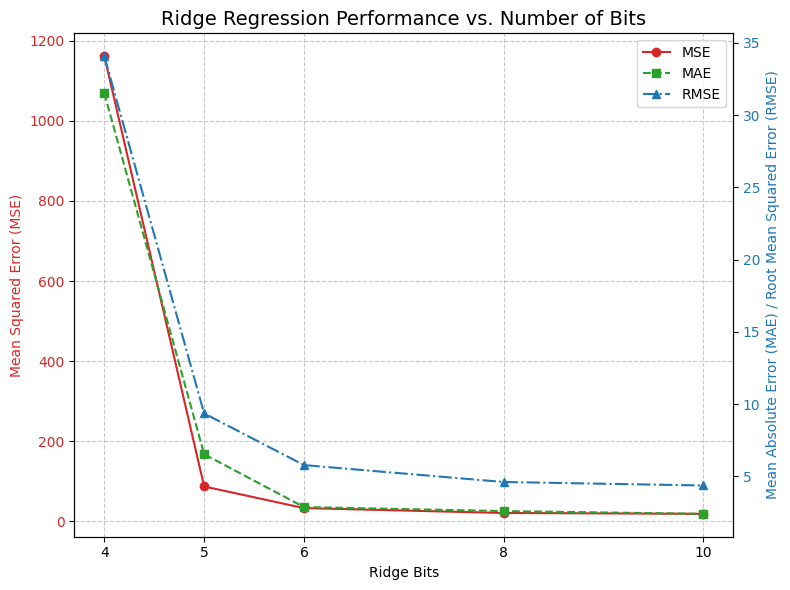

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
bits = [4, 5, 6, 8, 10]
mse = [1161.4358373449131, 87.40573682605505, 33.35124638125943, 21.19793535517247, 19.033317782160697]
mae = [31.517142562242867, 6.5281055137308295, 2.868349465474243, 2.590819450523437, 2.3995780846174473]
rmse = [34.079845031116456, 9.3491035306095, 5.775053798992649, 4.6041215617284115, 4.362719081279552]

# --- Create the plot ---
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot MSE
color = 'tab:red'
ax1.set_xlabel('Ridge Bits')
ax1.set_ylabel('Mean Squared Error (MSE)', color=color)
line1 = ax1.plot(bits, mse, marker='o', linestyle='-', color=color, label='MSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(bits)  # Ensure ticks are at the bit values
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis for MAE and RMSE
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mean Absolute Error (MAE) / Root Mean Squared Error (RMSE)', color=color)
line2 = ax2.plot(bits, mae, marker='s', linestyle='--', color='tab:green', label='MAE')
line3 = ax2.plot(bits, rmse, marker='^', linestyle='-.', color=color, label='RMSE')
ax2.tick_params(axis='y', labelcolor=color)

# --- Combine legends ---
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# --- Title and Aesthetics ---
plt.title('Ridge Regression Performance vs. Number of Bits', fontsize=14)
fig.tight_layout()  # Adjust layout to prevent labels from overlapping

# --- Show the plot ---
plt.show()